The goal of this analyses is to use LDA to model the words that occur in reviews as a mixture of topics containing different words. 2-grams and 3-grams are included in this approach. It makes sense to consider reviews this way because different coffee shops sell different sets of items to customers.  A customer can buy the same sets of items at two different coffee shops, so we don't need separate topics for each coffee shop

We expect different coffee shops to have review topic distributiosn that differ significantly between one another.  LDA is validated by checking coherence of words in topics with C_v measure.  Different hyper paramter sets are used.

In [1]:
import numpy as np
import pandas as pd


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [2]:
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./ProcessedData/allreviews_txtprocessed.csv')
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])
print(reviews.shape)
print(merged.head(3))
print(merged.name.value_counts().head(10))
print(merged.name.value_counts().tail(20))
print(merged.name.value_counts().shape)

(31806, 6)
                       id          name                  alias  is_closed  \
0  UZViRVpxNZvOM5KarmbT1g  Sweet Moment  sweet-moment-new-york      False   
1  UZViRVpxNZvOM5KarmbT1g  Sweet Moment  sweet-moment-new-york      False   
2  UZViRVpxNZvOM5KarmbT1g  Sweet Moment  sweet-moment-new-york      False   

                                          categories  review_count price  \
0  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...           822    $$   
1  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...           822    $$   
2  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...           822    $$   

   rating_x transactions  latitude  ...                    geometry  \
0       4.5           []  40.71763  ...  POINT (-73.99714 40.71763)   
1       4.5           []  40.71763  ...  POINT (-73.99714 40.71763)   
2       4.5           []  40.71763  ...  POINT (-73.99714 40.71763)   

                             catlist numcoffeemen  numreviews   fraccof  idx  \
0  ['coffe

In [3]:
# Load the regular expression library
import re
# Remove punctuation
merged['mreviewtxt'] = merged['mreviewtxt'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
merged['mreviewtxt'] = merged['mreviewtxt'].map(lambda x: x.lower())
# Print out the first rows of papers
merged['mreviewtxt'].head()

0    i can't believe i have never left a review for...
1    walked all the way across town to get my cute ...
2    definitely a beautiful cup of coffee it was a ...
3    i first came to sweet moment when my friend to...
4    okay so this place has by far has the best lat...
Name: mreviewtxt, dtype: object

In [4]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = merged.mreviewtxt.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['can', 'believe', 'have', 'never', 'left', 'review', 'for', 'this', 'place', 'considering', 'the', 'amount', 'of', 'times', 'stop', 'by', 'here', 'and', 'all', 'the', 'times', 'have', 'been', 'here', 'not', 'once', 'has', 'aone', 'been', 'rude', 'to', 'me', 'always', 'make', 'sure', 'to', 'get', 'latter', 'art', 'so', 'maybe', 'the', 'taro', 'or', 'red', 'velvet', 'or', 'matcha', 'to', 'be', 'honest', 'like', 'them', 'all', 'just', 'the', 'cuteness', 'of', 'it', 'makes', 'me', 'love', 'it', 'understandable', 'that', 'ma', 'people', 'don', 'wanna', 'pay', 'for', 'such', 'small', 'cups', 'of', 'latte', 'but', 'it', 'is', 'definitely', 'based', 'on', 'preference', 'second', 'the', 'bingsoo', 'here', 'is', 'so', 'so', 'good', 'the', 'one', 'get', 'the', 'most', 'has', 'to', 'be', 'the', 'mango', 'cheesecake', 'it', 'literally', 'has', 'lives', 'of', 'cheesecakes', 'and', 'has', 'condensed', 'milk', 'and', 'all', 'that', 'good', 'stuff', 'it', 'very', 'sweet', 'incase', 'don', 'like', 'th

Bi-grams and tri-grams

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Removing stopwords, making bigrams, and lemmatizing

In [7]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','good','great','love','go','always','go','order','get','say','try','nice','need','order','really','also','but','starbuck','dunkin','gregory','pret','bluestone','la colombe',
                  'starbucks','gregorys'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#we only focus on nouns and verbs since they probably provide the most distinct topic information
def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomasyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Calling the functions

In [8]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
print(data_lemmatized[2])

['coffee', 'bit', 'design', 'cream', 'special', 'base', 'coffee', 'tea', 'cream', 'tea', 'coffee', 'coffee', 'tea', 'cream', 'wish']


In [9]:
print(data_lemmatized[1:10])
bigramtokens = []
for doc in data_words_bigrams:
    for token in doc:
        if '_' in token:
            bigramtokens.append(token)
print(bigramtokens[2000:2050])

[['town', 'duper', 'seating', 'area', 'plenty', 'choice', 'stick', 'latte', 'art', 'drink', 'star', 'experience'], ['coffee', 'bit', 'design', 'cream', 'special', 'base', 'coffee', 'tea', 'cream', 'tea', 'coffee', 'coffee', 'tea', 'cream', 'wish'], ['moment', 'friend', 'summer', 'multiple', 'trip', 'month', 'summer', 'school', 'friend', 'moment', 'flavor', 'aone', 'flavor', 'suit', 'taste', 'moment', 'place', 'study', 'environment', 'focus', 'homework', 'vibe', 'picture', 'place', 'study', 'eat', 'dessert', 'moment', 'seat', 'worker'], ['place', 'latte', 'art', 'life', 'person', 'decorate', 'coffee', 'definite', 'girl', 'brunch', 'art', 'fare', 'list', 'con', 'place', 'customer', 'service', 'super', 'question', 'excuse', 'question', 'town', 'subway', 'parking', 'spot', 'dollar', 'hour', 'wifi', 'weekend', 'table', 'place', 'group', 'price', 'latte', 'place', 'con', 'variety', 'coffee', 'flavor', 'art', 'struggle'], ['shop', 'spot', 'invite', 'friend', 'couple', 'people', 'homework', 'o

Creating a dictionary and corpus for the LDA model

In [10]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])
print(len(corpus))
print(len(merged))
print(len(data_lemmatized))
print(len(id2word))
print(len(texts))

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2)]]
19590
19590
19590
10239
19590


Base Model

In [14]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [15]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.056*"place" + 0.044*"coffee" + 0.033*"work" + 0.031*"table" + '
  '0.026*"people" + 0.026*"space" + 0.024*"area" + 0.020*"starbuck" + '
  '0.020*"location" + 0.018*"seating"'),
 (1,
  '0.119*"food" + 0.061*"sandwich" + 0.053*"place" + 0.050*"breakfast" + '
  '0.036*"lunch" + 0.031*"option" + 0.021*"item" + 0.020*"price" + '
  '0.020*"juice" + 0.019*"spot"'),
 (2,
  '0.079*"milk" + 0.069*"drink" + 0.048*"starbuck" + 0.034*"coffee" + '
  '0.030*"barista" + 0.030*"latte" + 0.025*"time" + 0.020*"place" + '
  '0.019*"manager" + 0.016*"oat"'),
 (3,
  '0.039*"drink" + 0.027*"woman" + 0.024*"hotel" + 0.023*"issue" + '
  '0.018*"mocha" + 0.015*"vanilla" + 0.014*"man" + 0.014*"espresso" + '
  '0.013*"day" + 0.012*"smile"'),
 (4,
  '0.058*"customer" + 0.055*"time" + 0.050*"service" + 0.043*"location" + '
  '0.032*"people" + 0.031*"staff" + 0.030*"line" + 0.029*"minute" + '
  '0.028*"employee" + 0.022*"morning"'),
 (5,
  '0.032*"chain" + 0.028*"bagel" + 0.020*"ice" + 0.019*"fix" + 0.017*

When 10 topics are used some interesting combinations of topics show up.  Topic 6 appears to correspodn to pastries, Topic 9 to staff, office, quality,  Topic 7 to chocolate, capuccino.  Some topics contain a mixture of place related information (like office, train, traffic, morning, day), and food related information (chocolate, scone).  The dominant words in each topic correspond to food/coffee/tee while words like time, place,location, and seating have low probabiliteies among the reviews.

Baseline Coherence Score

In [22]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4129189817807785


Since hyperparameter tuning is kind of slow, just try to tune the number of topics rather than the alpha beta parameters.

In [11]:
# Build LDA model with 3 to 9 topics
ldamodlist = []
docldalist = []
cohereldalist = []
for nt in range(3,6):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=nt, 
                                       random_state=100,
                                       chunksize=100,
                                        passes=10,
                                       per_word_topics=True)
    print(f'Number of topics is:{nt}')
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    ldamodlist.append(lda_model)
    docldalist.append(doc_lda)
    cohereldalist.append(coherence_lda)
    


Number of topics is:3
[(0,
  '0.146*"coffee" + 0.048*"place" + 0.026*"shop" + 0.018*"milk" + 0.016*"work" '
  '+ 0.016*"area" + 0.015*"staff" + 0.014*"table" + 0.013*"space" + '
  '0.012*"spot"'),
 (1,
  '0.045*"food" + 0.023*"sandwich" + 0.023*"chocolate" + 0.022*"place" + '
  '0.021*"tea" + 0.020*"breakfast" + 0.014*"lunch" + 0.013*"flavor" + '
  '0.013*"cookie" + 0.013*"option"'),
 (2,
  '0.034*"time" + 0.031*"location" + 0.029*"drink" + 0.027*"service" + '
  '0.027*"customer" + 0.021*"line" + 0.021*"staff" + 0.019*"people" + '
  '0.015*"coffee" + 0.015*"morning"')]
Number of topics is:4
[(0,
  '0.050*"place" + 0.029*"table" + 0.027*"work" + 0.022*"people" + '
  '0.020*"space" + 0.020*"area" + 0.019*"coffee" + 0.017*"seat" + '
  '0.016*"seating" + 0.014*"staff"'),
 (1,
  '0.043*"food" + 0.028*"sandwich" + 0.023*"breakfast" + 0.023*"place" + '
  '0.022*"chocolate" + 0.020*"tea" + 0.016*"lunch" + 0.016*"cookie" + '
  '0.014*"option" + 0.013*"flavor"'),
 (2,
  '0.038*"time" + 0.033*"lo

Text(0.5, 1.0, 'Coherence vs Number of Topics LDA ')

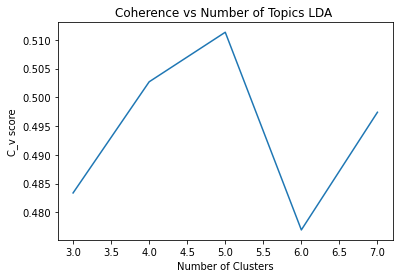

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.lineplot(x=range(3,8),y=cohereldalist,ax=ax)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('C_v score')
ax.set_title('Coherence vs Number of Topics LDA ')

#The coherence is highest when there are 5 clusters (0.51)

The coherence score is a little higher when 6 topics are used. 0.52 instead of 0.41

In [12]:
#Actually 5 topics is better when 'starbucks',and 'gregorys' are removed from reviews
from gensim.test.utils import datapath
from gensim.models import LdaModel
# Save model to disk.
temp_file = datapath("lda_nounsonly_5topics.gensim")
ldamodlist[2].save(temp_file)

ldamod3t = LdaModel.load(temp_file)


In [13]:
#saving the dictionary
from gensim import corpora
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
import pickle
pickle.dump(corpus, open('corpus_allreviews_nouns.pkl', 'wb'))
dictionary.save('dictionary_allreviews_nouns.gensim')


In [5]:
import pickle
from gensim.test.utils import datapath
from gensim.models import LdaModel
from gensim import corpora
#Visualize the LDA topics
dictionary = gensim.corpora.Dictionary.load('dictionary_allreviews_nouns.gensim')
corpus = pickle.load(open('corpus_allreviews_nouns.pkl', 'rb'))

temp_file = datapath("lda_nounsonly_5topics.gensim")
lda = gensim.models.ldamodel.LdaModel.load(temp_file)

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)



In [36]:
doclist2 = docldalist[2]
topicweights = []
for i in range(len(doclist2)):
    topicw = doclist2[i][0]
    toadd = [0 for i in range(5)]
    for (index,frac) in topicw:
        toadd[index] = frac
    topicweights.append(toadd)
topicweightdf = pd.DataFrame(topicweights)
topicweightdf.columns = ['t0','t1','t2','t3','t4']

NameError: name 'topicweightsdf' is not defined

In [40]:
topicweightdf['alias'] = merged.alias
topicweightdf['date'] = merged.date
topicweightdf['reviewtxt'] = merged.reviewtxt
topicweightdf['mreviewtxt'] = merged.mreviewtxt
topicweightdf.head(5)
topicweightdf.to_csv('./LDAresults/ldatopicweights_allreviews_5topics.csv',index=False)

In [79]:
#exploring the doc_lda
doclist3 = docldalist[3]
print(len(doclist3))
print(len(merged))
print(doclist3[0])
print(len(doclist3[0]))
print('first list in doclist3[0]')
print(doclist3[0][0])
print('length of 2nd list in doclist3[0]')
print(len(doclist3[0][1]))
print('data_lemmatized[0]')
print(data_lemmatized[0])
print(len(data_lemmatized[0]))
print(merged.reviewtxt[0])


19590
19590
([(0, 0.07720012), (2, 0.28036457), (3, 0.060510945), (4, 0.27330515), (5, 0.29990527)], [(0, [5, 4, 2, 3]), (1, [5, 2]), (2, [4]), (3, [4]), (4, [5, 3]), (5, [2, 4, 0]), (6, [4]), (7, [5]), (8, [4, 5, 2, 0]), (9, [0]), (10, [2]), (11, [5, 3, 0, 2]), (12, [5, 2, 4]), (13, [2]), (14, [2, 4, 3, 0]), (15, [5, 2, 3, 0]), (16, [4]), (17, [2, 5, 3, 4, 0])], [(0, [(2, 0.088868394), (3, 0.025242487), (4, 0.34965935), (5, 0.5361199)]), (1, [(2, 0.3724494), (5, 0.62741256)]), (2, [(4, 0.9704254)]), (3, [(4, 0.99937314)]), (4, [(3, 0.23781292), (5, 0.75967526)]), (5, [(0, 0.0398874), (2, 0.8370215), (4, 0.12304808)]), (6, [(4, 0.9746351)]), (7, [(5, 0.99936974)]), (8, [(0, 0.018951189), (2, 0.0384567), (4, 0.10991031), (5, 0.061534923)]), (9, [(0, 0.9962093)]), (10, [(2, 0.9978771)]), (11, [(0, 0.0779918), (2, 0.050287813), (3, 0.14465523), (5, 0.727047)]), (12, [(2, 0.3353542), (4, 0.03847308), (5, 0.61673373)]), (13, [(2, 0.9989006)]), (14, [(0, 0.069053695), (2, 0.43240085), (3, 0.

In [80]:
doclist3 = docldalist[3]
print(len(doclist3))
print(len(merged))
print(doclist3[200])
print(len(doclist3[200]))
print('first list in doclist3[200]')
print(doclist3[200][0])
print('length of 2nd list in doclist3[0]')
print(len(doclist3[200][1]))
print('data_lemmatized[0]')
print(data_lemmatized[200])
print(len(data_lemmatized[200]))
print(merged.reviewtxt[200])

19590
19590
([(2, 0.7232571), (5, 0.2570325)], [(10, [2]), (12, [2, 5]), (14, [2]), (20, [2, 5]), (23, [2, 5]), (31, [2, 5]), (43, [5, 2]), (50, [5]), (80, [5]), (82, [2, 5]), (90, [5]), (123, [5]), (183, [2, 5]), (185, [2, 5]), (197, [2]), (204, [2, 5]), (256, [5]), (320, [2]), (348, [2]), (433, [2]), (444, [2]), (608, [2, 5]), (626, [2]), (781, [2, 5]), (859, [2]), (860, [2]), (861, [2]), (862, [2])], [(10, [(2, 2.999985)]), (12, [(2, 1.2621312), (5, 0.7377541)]), (14, [(2, 0.99967)]), (20, [(2, 0.8593746), (5, 0.14037992)]), (23, [(2, 0.9688772), (5, 0.031112444)]), (31, [(2, 2.662524), (5, 0.33747336)]), (43, [(2, 0.44088784), (5, 0.5589997)]), (50, [(5, 0.9999687)]), (80, [(5, 0.99997604)]), (82, [(2, 0.515228), (5, 0.4846151)]), (90, [(5, 0.99988955)]), (123, [(5, 0.9994988)]), (183, [(2, 0.7400612), (5, 0.2597474)]), (185, [(2, 0.606823), (5, 0.39304286)]), (197, [(2, 0.99985105)]), (204, [(2, 0.7099869), (5, 0.28959993)]), (256, [(5, 0.9993788)]), (320, [(2, 0.9993876)]), (348,

In [94]:
test = lda[corpus]
test[0][1:3]

([(0, [5, 4, 2, 3]),
  (1, [5, 2]),
  (2, [4]),
  (3, [4]),
  (4, [5, 3]),
  (5, [2, 4, 0]),
  (6, [4]),
  (7, [5]),
  (8, [4, 5, 2, 0]),
  (9, [0]),
  (10, [2]),
  (11, [5, 3, 0, 2]),
  (12, [5, 2, 4]),
  (13, [2]),
  (14, [2, 4, 3, 0]),
  (15, [5, 2, 3, 0]),
  (16, [4]),
  (17, [2, 5, 3, 4, 0])],
 [(0, [(2, 0.08889181), (3, 0.026211245), (4, 0.35002545), (5, 0.53476137)]),
  (1, [(2, 0.373104), (5, 0.6267575)]),
  (2, [(4, 0.9704182)]),
  (3, [(4, 0.99937314)]),
  (4, [(3, 0.24517326), (5, 0.75232977)]),
  (5, [(0, 0.039894335), (2, 0.83693135), (4, 0.12313121)]),
  (6, [(4, 0.97463095)]),
  (7, [(5, 0.9993673)]),
  (8, [(0, 0.018937396), (2, 0.03841789), (4, 0.109885395), (5, 0.061300896)]),
  (9, [(0, 0.9962064)]),
  (10, [(2, 0.9978756)]),
  (11, [(0, 0.077741615), (2, 0.050112385), (3, 0.14964339), (5, 0.7224845)]),
  (12, [(2, 0.33592257), (4, 0.03856847), (5, 0.6160512)]),
  (13, [(2, 0.99889934)]),
  (14, [(0, 0.06877742), (2, 0.43054962), (3, 0.10772787), (4, 0.39283592)]),
 

Starbucks dominates the data set (3944 reviews ) vs the next most (Dunkin with 800 reviews), and 380 for La Colombe Coffee. The topics identified cover a very diverse set of coffee shops, with very different customer bases as well.  If we were to focus on a more niche coffe shop like La Colombe, would we get the same pattern of topics?  This is important because the topics we obtained by performin LDA on the whole set might not be enough to adequately describe the differences between reviews for a subset.

In [58]:
# Build LDA model with 3 to 9 topics for only La Colombe coffee shops


def getid2wordandcorpus(data_lemmatized,texts):
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    result = {}
    result['id2word'] = id2word
    result['corpus'] = corpus
    return(result)

def getcoherencevstopick(data_lemmatized,corpus,id2word,mink,maxk):
    ldamodlist = []
    docldalist = []
    cohereldalist = []
    for nt in range(mink,maxk+1):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                       num_topics=nt, 
                                       random_state=100,
                                       chunksize=100,
                                        passes=10,
                                       per_word_topics=True)
        print(f'Number of topics is:{nt}')
        pprint(lda_model.print_topics())
        doc_lda = lda_model[corpus]
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        ldamodlist.append(lda_model)
        docldalist.append(doc_lda)
        cohereldalist.append(coherence_lda)
    result = {}
    result['ldamodlist']  = ldamodlist
    result['docldalist'] = docldalist
    result['cohereldalist'] = cohereldalist
    return(result)
    

TypeError: 'LdaMulticore' object is not callable

In [59]:
#Performing LDA topic modeling on La Colombe Nouns
lcdata_lemmatized = [data_lemmatized[i] for i in range(len(merged)) if merged.name[i]=='La Colombe Coffee']
lctexts = [texts[i] for i in range(len(merged)) if merged.name[i]=='La Colombe Coffee']
print(lctexts[1])

dict1 = getid2wordandcorpus(lcdata_lemmatized,lctexts)
dict2 = getcoherencevstopick(lcdata_lemmatized,dict1['corpus'],dict1['id2word'],3,10)



['fact', 'lid', 'straw', 'provide', 'straw', 'location', 'work', 'time', 'drink', 'draft', 'latte', 'friend', 'latte', 'shot', 'time', 'coffee', 'shop', 'seating', 'area']
Number of topics is:3
[(0,
  '0.067*"coffee" + 0.029*"line" + 0.017*"morning" + 0.015*"shop" + '
  '0.015*"draft" + 0.014*"time" + 0.013*"day" + 0.012*"service" + '
  '0.012*"place" + 0.011*"barista"'),
 (1,
  '0.109*"coffee" + 0.029*"location" + 0.028*"place" + 0.020*"time" + '
  '0.013*"draft" + 0.013*"milk" + 0.012*"people" + 0.012*"staff" + '
  '0.012*"drink" + 0.012*"line"'),
 (2,
  '0.074*"latte" + 0.063*"milk" + 0.060*"draft" + 0.059*"coffee" + 0.047*"oat" '
  '+ 0.020*"drink" + 0.012*"shop" + 0.010*"place" + 0.010*"flavor" + '
  '0.008*"attitude"')]
Number of topics is:4
[(0,
  '0.071*"coffee" + 0.033*"line" + 0.019*"morning" + 0.017*"time" + '
  '0.016*"place" + 0.016*"draft" + 0.014*"service" + 0.014*"tea" + 0.013*"lot" '
  '+ 0.012*"shop"'),
 (1,
  '0.107*"coffee" + 0.026*"place" + 0.026*"location" + 0.022

Text(0.5, 1.0, 'Coherence vs Number of Topics LDA for La Colombe Reviews ')

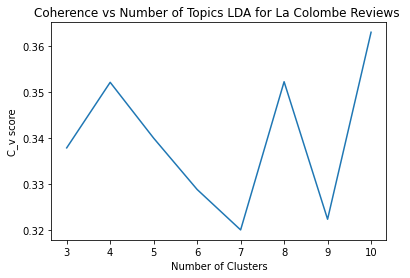

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.lineplot(x=range(3,11),y=dict2['cohereldalist'],ax=ax)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('C_v score')
ax.set_title('Coherence vs Number of Topics LDA for La Colombe Reviews ')

When LDA was performed on the La Colombe Coffee reviews, there was a large overlap in the top words for the topics. For example, coffee, latte, draft, drink, and time appear in multiple topics.  

Hyperparamater Tuning

In [18]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

Iterating the function over different hyperparameters.

In [19]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 3
max_topics = 8
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.3, 1, 0.8))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.3, 1, 0.8))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  6%|▋         | 35/540 [45:57<12:26:19, 88.67s/it]Process ForkPoolWorker-218:
Process ForkPoolWorker-219:
Process ForkPoolWorker-217:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/thomasyoung/opt/an

KeyboardInterrupt: 

## Plotting the model results


In [ ]:
import seaborn as sns
import matplotlib as plt

In [27]:
model_results

{'Validation_Set': [], 'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}

In [30]:
int(0.5*9)

4